# Finding optimal hyper parameters for a CNN model

The point of this notebook is to obtain an optimal set of parameters for our CNN model to process time based series data. Specifically, we are processing IoT data from TON a well-kept dataset from The UNSW Group in Canberra, Australia.

The specific dataset being discussed here is the IoT GPS Tracker dataset.



We have pip install mealpy each time because it is not a default python package ,and every time the runtime refreshes; the package is uninstalled.

In [ ]:
%pip install mealpy==3.0.1
%pip install -U scikit-learn
%pip install imbalanced-learn
%pip install matplotlib
%pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 626.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.3/386.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 13.9 MB/s eta 0:00:00


Our main libraries used are:

*   Imblearn
*   Pandas
*   Matplot Lib
*   MealPy
*   Numpy
*   SKLearn
*   Tensorflow
*   Time



In [ ]:
import pandas
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from imblearn.combine import SMOTETomek
import numpy
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt
from mealpy import FloatVar, LCO
import time

# Preparing the Datasets for the CNN Model

We split off the information that indicates whether or not an attack has occured (*label*) and the types of attacks (*type*).
Now there are three dataframes:
  X - all features
  y - attack or not
  y_type - type of attack

We split again into test and train data sets and include some randomness.
**Reset_index** drops the indexes from these new dataframes.
Next, we encode the text data, add another randomness, and scale all dataframes. The X dataframe is reshaped.

In [ ]:
#Uncomment for local use
#raw_data = pandas.read_csv('../../Train_Test_IoT_dataset/Train_Test_IoT_GPS_Tracker.csv')
#Uncomment for Google Colab
raw_data = pandas.read_csv('Train_Test_IoT_GPS_Tracker.csv')
X = raw_data.drop(columns=['label','type'])
y = raw_data['label']
y_type = raw_data['type']

In [ ]:
# Binary
X_train, X_testsplit, y_train, y_testsplit = train_test_split(X, y, test_size=0.2, random_state=777)
# Binary validation
X_test, X_validation, y_test, y_validation = train_test_split(X_testsplit, y_testsplit, test_size=0.5, random_state=777)

#drop index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
X_validation = X_validation.reset_index(drop=True)
y_validation = y_validation.reset_index(drop=True)

In [ ]:
encoder = OrdinalEncoder()
label_encoder = LabelEncoder()
X_train_encode = encoder.fit_transform(X_train)
X_test_encode = encoder.fit_transform(X_test)
y_train_encode = label_encoder.fit_transform(y_train)
y_test_encode = label_encoder.fit_transform(y_test)
X_validation_encode = encoder.fit_transform(X_validation)
y_validation_encode = label_encoder.fit_transform(y_validation)

In [ ]:
smotetomek = SMOTETomek(random_state=777)
X_rebalance, y_rebalance = smotetomek.fit_resample(X_train_encode, y_train_encode)

In [ ]:
scaler = StandardScaler()
X_rebalance = scaler.fit_transform(X_rebalance)
X_test_encode = scaler.transform(X_test_encode)

X_validation_encode = scaler.transform(X_validation_encode)

In [ ]:
X_rebalance = X_rebalance.reshape(X_rebalance.shape[0], X_rebalance.shape[1], 1)
X_test_encode = X_test_encode.reshape(X_test_encode.shape[0], X_test_encode.shape[1], 1)

X_validation_encode = X_validation_encode.reshape(X_validation_encode.shape[0], X_validation_encode.shape[1], 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2, 50)          │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 50)          │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,633 (248.57 KB)

 Trainable params: 63,533 (248.18 KB)

 Non-trainable params: 100 (400.00 B)

Epoch 1/70
600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.5063 - loss: 0.6937 - val_accuracy: 0.3904 - val_loss: 0.6934
Epoch 2/70
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.5118 - loss: 0.6927 - val_accuracy: 0.3904 - val_loss: 0.6931
Epoch 3/70
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5250 - loss: 0.6916 - val_accuracy: 0.3904 - val_loss: 0.6928
Epoch 4/70
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5321 - loss: 0.6911 - val_accuracy: 0.3904 - val_loss: 0.6925
Epoch 5/70
600/600 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.5375 - loss: 0.6903 - val_accuracy: 0.3904 - val_loss: 0.6924
Epoch 6/70
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5440 - loss: 0.6897 - val_accuracy: 0.3904 - val_loss: 0.6922
Epoch 7/70
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5455 - loss: 0.6894 - val_accuracy: 0.3904 - val_loss: 0.6919
Epoch 8/70
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5572 - loss: 0.6878 - val_accuracy:

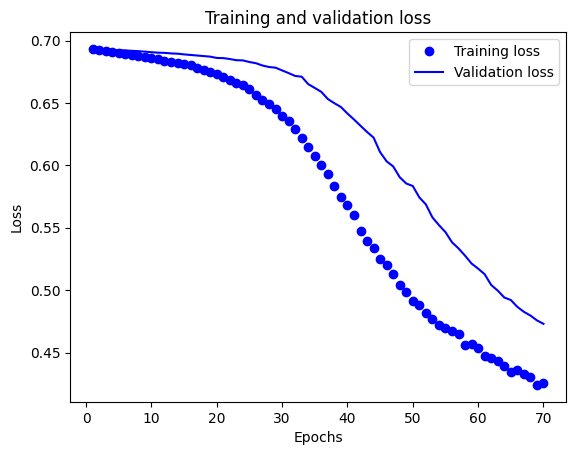

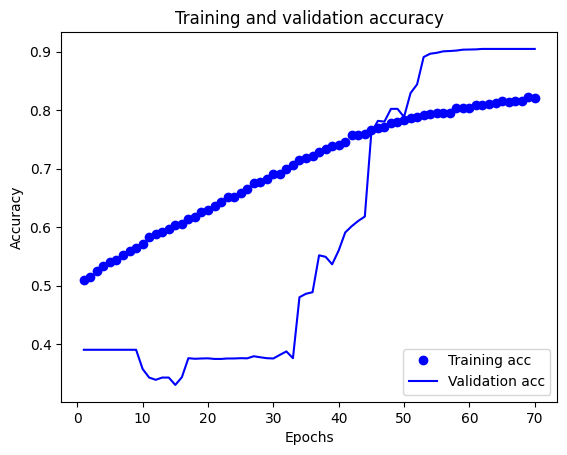


Classification Report
              precision    recall  f1-score   support

           0       1.00      0.73      0.85      1527
           1       0.85      1.00      0.92      2369

    accuracy                           0.90      3896
   macro avg       0.93      0.87      0.88      3896
weighted avg       0.91      0.90      0.89      3896


Confusion Matrix
[[1120  407]
 [   0 2369]]


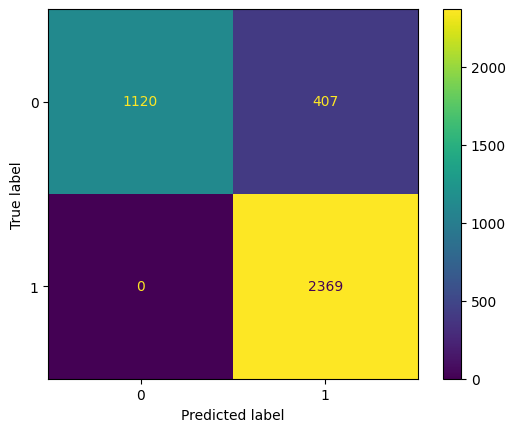

Time taken: 353.6928 seconds


In [ ]:
start_time_1 = time.perf_counter()
with tensorflow.device('/device:GPU:0'):
  # CNN model detection
  # https://keras.io/api/layers/activations/#softmax-function
  detection_model = tensorflow.keras.Sequential([
      tensorflow.keras.layers.Input(shape=(X_rebalance.shape[1],X_rebalance.shape[2])),
      tensorflow.keras.layers.Conv1D(filters=50, kernel_size=3, activation='sigmoid'),
      tensorflow.keras.layers.MaxPooling1D(pool_size=2),
      tensorflow.keras.layers.Dropout(0.3),
      tensorflow.keras.layers.BatchNormalization(),
      tensorflow.keras.layers.LSTM(64),
      tensorflow.keras.layers.Flatten(),
      # 1 layer
      tensorflow.keras.layers.Dense(512, activation='relu'),
      tensorflow.keras.layers.Dropout(0.5),
      # either attack or normal
      tensorflow.keras.layers.Dense(1, activation='sigmoid')
  ])

  detection_model.summary()
  # https://keras.io/api/losses/probabilistic_losses/#probabilistic-losses
  sgd = tensorflow.keras.optimizers.SGD(learning_rate=0.001)
  detection_model.compile(optimizer=sgd,
                loss=tensorflow.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])

  history = detection_model.fit(X_rebalance, y_rebalance, batch_size=64, epochs=70, validation_data=(X_validation_encode, y_validation_encode))
  test_loss, test_acc = detection_model.evaluate(X_test_encode, y_test_encode)

  # Make predictions
  prediction = detection_model.predict(X_test_encode)
  print(prediction)
  attack_prediction = numpy.where(prediction > 0.5, 1, 0)
  print(attack_prediction)
  print(y_test)

  # Evaluate the model
  print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}\n")
  # https://www.tensorflow.org/tutorials/keras/text_classification for training and validation loss and accuracy
  history_dict = history.history
  # print(history_dict.keys())
  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)

  # "bo" is for "blue dot"
  plt.plot(epochs, loss, 'bo', label='Training loss')
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  print("\n")

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.show()

  print("\nClassification Report")
  print(classification_report(y_test, attack_prediction))

  print("\nConfusion Matrix")
  print(confusion_matrix(y_test, attack_prediction))
  ConfusionMatrixDisplay.from_predictions(y_test, attack_prediction)
  plt.show()

end_time1 = time.perf_counter()
print(f"Time taken: {end_time1 - start_time_1:0.4f} seconds")

# Optimizing the model
Instead of looking at random number ranges for learning rates, filters, and hidden units, we have encoded specific values.

The hyper parameters we are attempting to optimize are:

*   Batch Size
*   Activation Functions
*   Learning Rates
*   Filters
*   Hidden Units


The base CNN model we made is ingested into *objective_function*.
  This is where our hyper parameters are being considered.
  It returns the Accuracy of that particular iteration.
**LB** and **UB** is set according to the list given above.



2025/04/11 11:03:25 AM, INFO, mealpy.human_based.LCO.OriginalLCO: Solving single objective optimization problem.


Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.482802927

2025/04/11 11:27:35 AM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 1, Current best: 0.4828029274940491, Global best: 0.4828029274940491, Runtime: 719.40034 seconds


Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491


2025/04/11 11:39:24 AM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 2, Current best: 0.4828029274940491, Global best: 0.4828029274940491, Runtime: 708.89391 seconds


Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.5171970427036285
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.5171970427036285
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491


2025/04/11 11:55:04 AM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 3, Current best: 0.4828029274940491, Global best: 0.4828029274940491, Runtime: 940.33946 seconds


Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491


2025/04/11 12:08:37 PM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 4, Current best: 0.4828029274940491, Global best: 0.4828029274940491, Runtime: 813.52991 seconds


Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.3117968440055847
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491


2025/04/11 12:22:06 PM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 5, Current best: 0.3117968440055847, Global best: 0.3117968440055847, Runtime: 808.09948 seconds


Accuracy 0.4828029274940491
Accuracy 0.4779813289642334
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.5171970427036285
Accuracy 0.35936999320983887
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491


2025/04/11 12:37:16 PM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 6, Current best: 0.3117968440055847, Global best: 0.3117968440055847, Runtime: 910.57237 seconds


Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.47894567251205444
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491


2025/04/11 12:51:35 PM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 7, Current best: 0.3117968440055847, Global best: 0.3117968440055847, Runtime: 858.88858 seconds


Accuracy 0.4828029274940491
Accuracy 0.4799100160598755
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.5171970427036285
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.585663765668869
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.2671166658401489
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.5171970427036285
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491


2025/04/11 01:06:19 PM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 8, Current best: 0.2671166658401489, Global best: 0.2671166658401489, Runtime: 883.53263 seconds


Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491


2025/04/11 01:19:11 PM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 9, Current best: 0.2671166658401489, Global best: 0.2671166658401489, Runtime: 772.30628 seconds


Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491


2025/04/11 01:32:18 PM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 10, Current best: 0.2671166658401489, Global best: 0.2671166658401489, Runtime: 787.40341 seconds


Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285


2025/04/11 01:45:34 PM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 11, Current best: 0.2671166658401489, Global best: 0.2671166658401489, Runtime: 795.46399 seconds


Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.6406300365924835
Accuracy 0.5171970427036285


2025/04/11 06:59:15 PM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 12, Current best: 0.2671166658401489, Global best: 0.2671166658401489, Runtime: 18821.63812 seconds


Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491


2025/04/11 07:13:40 PM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 13, Current best: 0.2671166658401489, Global best: 0.2671166658401489, Runtime: 864.87497 seconds


Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491


2025/04/11 07:27:47 PM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 14, Current best: 0.2671166658401489, Global best: 0.2671166658401489, Runtime: 846.48240 seconds


Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.32594019174575806
Accuracy 0.22275793552398682
Accuracy 0.4828029274940491
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491
Accuracy 0.5171970427036285
Accuracy 0.4828029274940491


2025/04/11 07:41:13 PM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 15, Current best: 0.22275793552398682, Global best: 0.22275793552398682, Runtime: 806.57152 seconds


Accuracy 0.4828029274940491
Solution: [2.02488104 5.85624779 2.20671117 1.82980948 2.07767342], Fitness: 0.22275793552398682
Solution: [2.02488104 5.85624779 2.20671117 1.82980948 2.07767342], Fitness: 0.22275793552398682


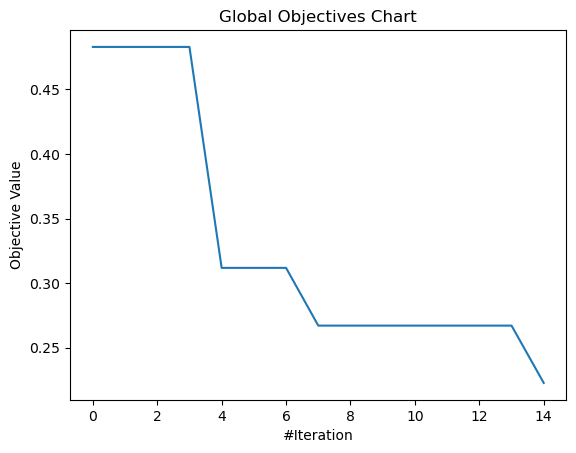

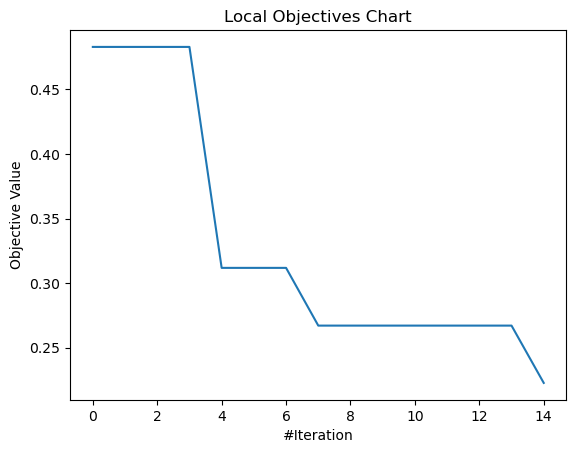

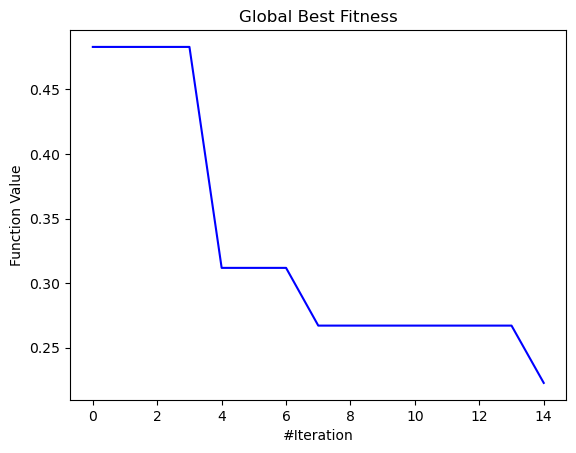

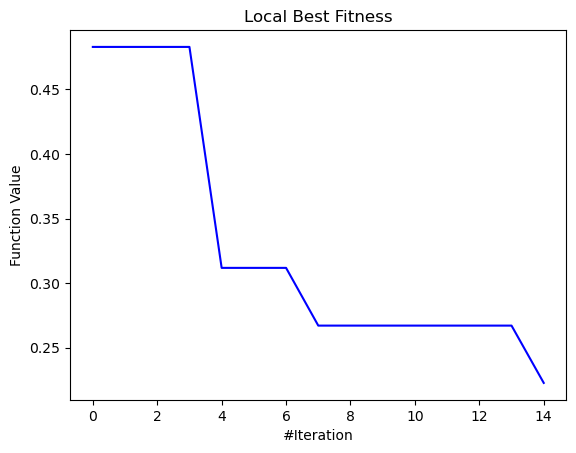

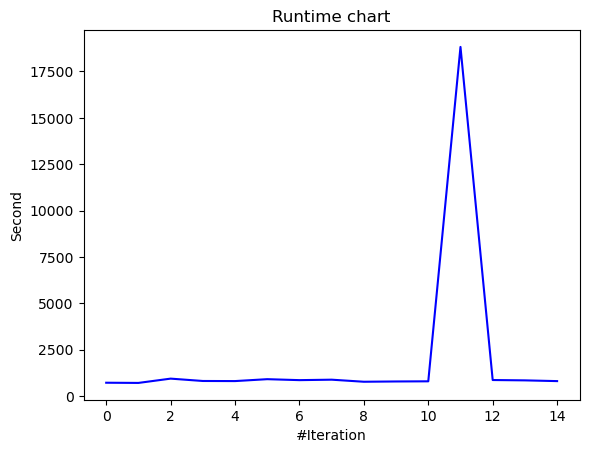

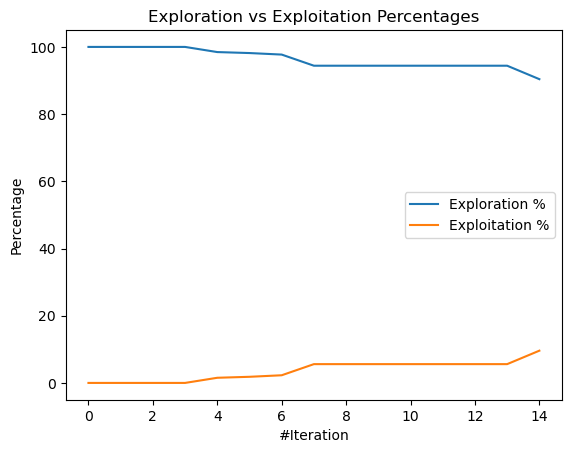

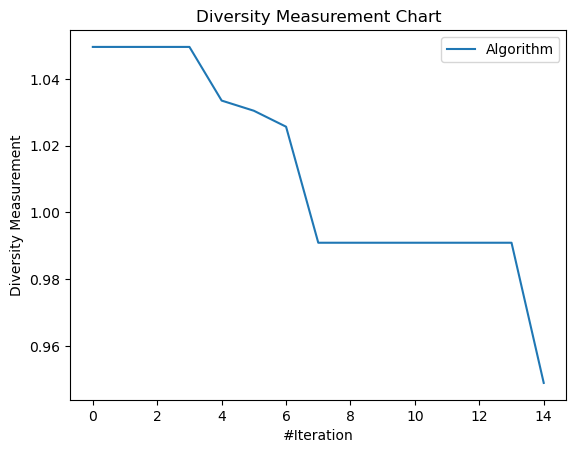

In [ ]:
BATCH_ENCODER = LabelEncoder()
BATCH_ENCODER.fit([32, 64, 128])

#act encoder --> Which activation function should be used?
ACT_ENCODER = LabelEncoder()
ACT_ENCODER.fit(['softmax', 'softplus', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'])

#Learning Rate encoder
LR_ENCODER = LabelEncoder()
LR_ENCODER.fit([0.0005, 0.001, 0.005, 0.01, 0.05, 0.1])

#Filter encoder
FILTER_ENCODER = LabelEncoder()
FILTER_ENCODER.fit([25, 50, 75])

#Hidden Units encoder
HIDDEN_ENCODER = LabelEncoder()
HIDDEN_ENCODER.fit([400, 512, 640])

def objective_function(params):
  '''RULES:
      Batch Size - 32, 64, 128
      Activation - softmax, softplus, relu, tanh, sigmoid, hard_sigmoid, linear
      Learning Rate - 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1
      Filters - 25, 50, 75
      Hidden Units - 400, 512, 640
      Dense Layers - 5, 8, 10
  '''
  batch_size = BATCH_ENCODER.inverse_transform([int(params[0])])[0]
  activation = ACT_ENCODER.inverse_transform([int(params[1])])[0]
  learning_rate = LR_ENCODER.inverse_transform([int(params[2])])[0]
  filter = FILTER_ENCODER.inverse_transform([int(params[3])])[0]
  hidden_units = HIDDEN_ENCODER.inverse_transform([int(params[4])])[0]

  model = tensorflow.keras.Sequential()
  model.add(tensorflow.keras.layers.Input(shape=(X_rebalance.shape[1], X_rebalance.shape[2]))),
  model.add(tensorflow.keras.layers.Conv1D(filters=filter, kernel_size=3, activation='sigmoid')),
  model.add(tensorflow.keras.layers.MaxPooling1D(pool_size=2)),
  model.add(tensorflow.keras.layers.Dropout(0.3)),
  model.add(tensorflow.keras.layers.BatchNormalization()),
  model.add(tensorflow.keras.layers.LSTM(64)),
  model.add(tensorflow.keras.layers.Flatten()),
  model.add(tensorflow.keras.layers.Dense(int(hidden_units), activation=activation)),
  model.add(tensorflow.keras.layers.Dropout(0.5)),
  model.add(tensorflow.keras.layers.Dense(1, activation='sigmoid'))


  optimizer = tensorflow.keras.optimizers.SGD(learning_rate=learning_rate)
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

  history = model.fit(X_rebalance, y_rebalance, batch_size=batch_size, epochs=15, validation_data=(X_validation_encode, y_validation_encode), verbose=0)
  min_validation_accuracy = 1-history.history['val_accuracy'][-1]
  print(f"Accuracy {min_validation_accuracy}")
  return min_validation_accuracy

LB = [0, 0, 0, 0, 0]
UB = [2.99, 6.99, 5.99, 2.99, 2.99]

problem_dict = {
    "obj_func": objective_function,
    "bounds": FloatVar(lb=LB, ub=UB),
    "minmax": "min",
    "verbose": True
}

model = LCO.OriginalLCO(epoch=15, pop_size=20, r1=2.35)
g_best = model.solve(problem_dict)
print(f"Solution: {g_best.solution}, Fitness: {g_best.target.fitness}")
print(f"Solution: {model.g_best.solution}, Fitness: {model.g_best.target.fitness}")
model.history.save_global_objectives_chart(filename="gps_tracker/goc")
model.history.save_local_objectives_chart(filename="gps_tracker/loc")

model.history.save_global_best_fitness_chart(filename="gps_tracker/gbfc")
model.history.save_local_best_fitness_chart(filename="gps_tracker/lbfc")

model.history.save_runtime_chart(filename="gps_tracker/rtc")

model.history.save_exploration_exploitation_chart(filename="gps_tracker/eec")

model.history.save_diversity_chart(filename="gps_tracker/dc")


Solution: [2.02488104 5.85624779 2.20671117 1.82980948 2.07767342], Fitness: 0.22275793552398682

Batch Size - 32, 64, **128**

Activation - softmax, softplus, relu, tanh, sigmoid, **hard_sigmoid**, linear

Learning Rate - 0.0005, 0.001, **0.005**, 0.01, 0.05, 0.1

Filters - 25, **50**, 75

Hidden Units - 400, 512, **640**

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 2, 50)          │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 50)          │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 640)            │        41,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           641 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,081 (281.57 KB)

 Trainable params: 71,981 (281.18 KB)

 Non-trainable params: 100 (400.00 B)

Epoch 1/70
300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.5034 - loss: 0.7594 - val_accuracy: 0.3904 - val_loss: 0.6952
Epoch 2/70
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5071 - loss: 0.7360 - val_accuracy: 0.6096 - val_loss: 0.6904
Epoch 3/70
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5006 - loss: 0.7354 - val_accuracy: 0.3904 - val_loss: 0.7066
Epoch 4/70
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.4995 - loss: 0.7296 - val_accuracy: 0.3904 - val_loss: 0.6979
Epoch 5/70
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5027 - loss: 0.7224 - val_accuracy: 0.3904 - val_loss: 0.6973
Epoch 6/70
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.4989 - loss: 0.7179 - val_accuracy: 0.3904 - val_loss: 0.7008
Epoch 7/70
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5042 - loss: 0.7117 - val_accuracy: 0.3904 - val_loss: 0.7057
Epoch 8/70
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4935 - loss: 0.7121 - val_accuracy

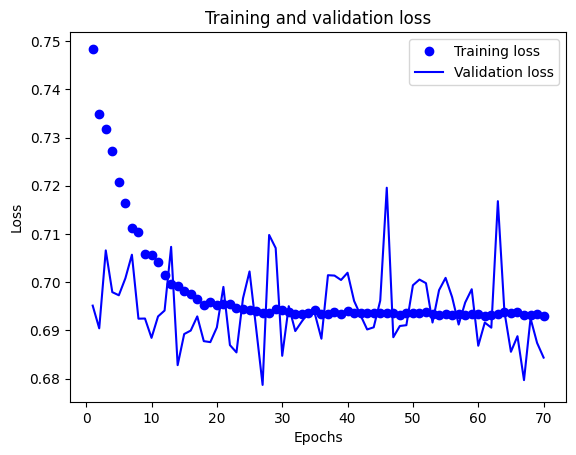

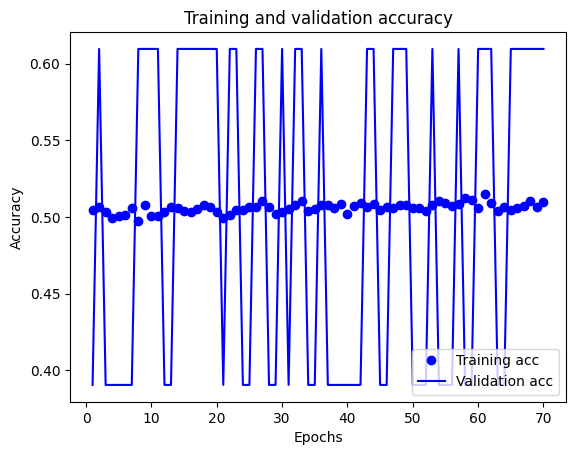


Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1527
           1       0.61      1.00      0.76      2369

    accuracy                           0.61      3896
   macro avg       0.30      0.50      0.38      3896
weighted avg       0.37      0.61      0.46      3896


Confusion Matrix
[[   0 1527]
 [   0 2369]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


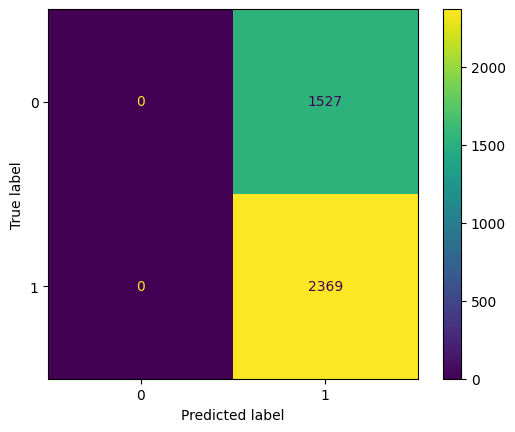

Time taken: 274.5574 seconds


In [ ]:
start_time_2 = time.perf_counter()
with tensorflow.device('/device:GPU:0'):
  # CNN model detection
  # https://keras.io/api/layers/activations/#softmax-function
  detection_model = tensorflow.keras.Sequential([
      tensorflow.keras.layers.Input(shape=(X_rebalance.shape[1],X_rebalance.shape[2])),
      tensorflow.keras.layers.Conv1D(filters=50, kernel_size=3, activation='sigmoid'),
      tensorflow.keras.layers.MaxPooling1D(pool_size=2),
      tensorflow.keras.layers.Dropout(0.3),
      tensorflow.keras.layers.BatchNormalization(),
      tensorflow.keras.layers.LSTM(64),
      tensorflow.keras.layers.Flatten(),
      # 1 layer
      tensorflow.keras.layers.Dense(640, activation='hard_sigmoid'),
      tensorflow.keras.layers.Dropout(0.5),
      # either attack or normal
      tensorflow.keras.layers.Dense(1, activation='sigmoid')
  ])

  detection_model.summary()
  # https://keras.io/api/losses/probabilistic_losses/#probabilistic-losses
  sgd = tensorflow.keras.optimizers.SGD(learning_rate=0.005)
  detection_model.compile(optimizer=sgd,
                loss=tensorflow.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])

  history = detection_model.fit(X_rebalance, y_rebalance, batch_size=128, epochs=70, validation_data=(X_validation_encode, y_validation_encode))
  test_loss, test_acc = detection_model.evaluate(X_test_encode, y_test_encode)

  # Make predictions
  prediction = detection_model.predict(X_test_encode)
  print(prediction)
  attack_prediction = numpy.where(prediction > 0.5, 1, 0)
  print(attack_prediction)
  print(y_test)

  # Evaluate the model
  print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}\n")
  # https://www.tensorflow.org/tutorials/keras/text_classification for training and validation loss and accuracy
  history_dict = history.history
  # print(history_dict.keys())
  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)

  # "bo" is for "blue dot"
  plt.plot(epochs, loss, 'bo', label='Training loss')
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  print("\n")

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.show()

  print("\nClassification Report")
  print(classification_report(y_test, attack_prediction))

  print("\nConfusion Matrix")
  print(confusion_matrix(y_test, attack_prediction))
  ConfusionMatrixDisplay.from_predictions(y_test, attack_prediction)
  plt.show()

end_time2 = time.perf_counter()
print(f"Time taken: {end_time2 - start_time_2:0.4f} seconds")
